In [1]:
!pip install -q transformers datasets

In [5]:
import os
import random
from datasets import Dataset, load_dataset
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomRotation, RandomAdjustSharpness, Resize, ToTensor)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Verilerin bulunduğu klasör (Replace with your actual path)
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

def load_image_data(data_dir):
    image_paths = []
    labels = []
    for label in ['no', 'yes']:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(1 if label == 'yes' else 0)  # 1 for 'yes', 0 for 'no'
    return image_paths, labels

image_paths, labels = load_image_data(data_dir)

# Split data into training and testing sets (80/20 split)
dataset_size = len(image_paths)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_indices = random.sample(range(dataset_size), train_size)
test_indices = [i for i in range(dataset_size) if i not in train_indices]

train_data = Dataset.from_dict({
    'image': [image_paths[i] for i in train_indices],
    'label': [labels[i] for i in train_indices]
})

test_data = Dataset.from_dict({
    'image': [image_paths[i] for i in test_indices],
    'label': [labels[i] for i in test_indices]
})

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


Map:   0%|          | 0/143 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in y

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.661275,0.750000
2,No log,0.616004,0.861111
3,No log,0.571816,0.861111
4,No log,0.529738,0.861111
5,No log,0.493398,0.888889
6,No log,0.463134,0.888889
7,No log,0.435847,0.916667
8,No log,0.410632,0.972222
9,No log,0.392600,0.972222
10,No log,0.377957,0.972222


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Confusion Matrix:
[[20  0]
 [ 1 15]]


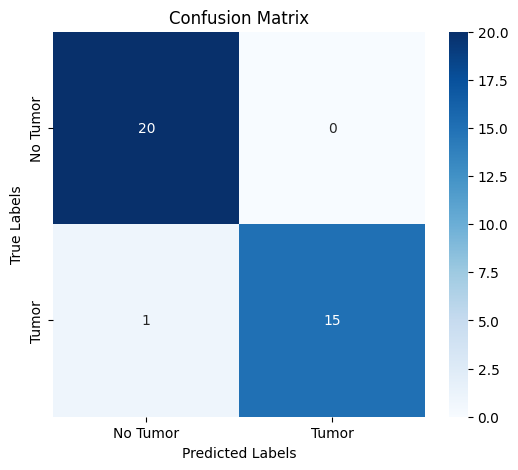


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      1.00      0.98        20
       Tumor       1.00      0.94      0.97        16

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



In [6]:
# ViT ImageProcessor yükle
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

# Veri augmentasyonu için transformasyonları tanımla
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(15),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize,
])

# Veriyi ön işlemek için fonksiyonlar
def transforms(examples, transform_func):
    images = [Image.open(path).convert("RGB") for path in examples["image"]]
    examples["pixel_values"] = [transform_func(image) for image in images]
    return examples

# Apply transformations using the map function
train_data = train_data.map(lambda examples: transforms(examples, _train_transforms), batched=True, batch_size=32)
test_data = test_data.map(lambda examples: transforms(examples, _val_transforms), batched=True, batch_size=32)

# Model and training parameters (simplified id2label/label2id, explicit num_labels)
id2label = {0: 'no', 1: 'yes'}
label2id = {'no': 0, 'yes': 1}

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2, id2label=id2label, label2id=label2id)

args = TrainingArguments(
    "Brain-Tumor-Detection",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

trainer.train()

# Save the model
model.save_pretrained("saved_model")

# Make predictions on the test set
predictions = trainer.predict(test_data)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["No Tumor", "Tumor"]))